# Regularization

Welcome to the second assignment of this week. Deep Learning models have so much flexibility and capacity that **overfitting can be a serious problem**, if the training dataset is not big enough. Sure it does well on the training set, but the learned network **doesn't generalize to new examples** that it has never seen!

**You will learn to:** Use regularization in your deep learning models.

Let's first import the packages you are going to use.

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from reg_utils import sigmoid, relu, plot_decision_boundary, initialize_parameters, load_2D_dataset, predict_dec
from reg_utils import compute_cost, predict, forward_propagation, backward_propagation, update_parameters
import sklearn
import sklearn.datasets
import scipy.io
from testCases import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

**Problem Statement**: You have just been hired as an AI expert by the French Football Corporation. They would like you to recommend positions where France's goal keeper should kick the ball so that the French team's players can then hit it with their head. 

<img src="images/field_kiank.png" style="width:600px;height:350px;">
<caption><center> <u> **Figure 1** </u>: **Football field**<br> The goal keeper kicks the ball in the air, the players of each team are fighting to hit the ball with their head </center></caption>


They give you the following 2D dataset from France's past 10 games.

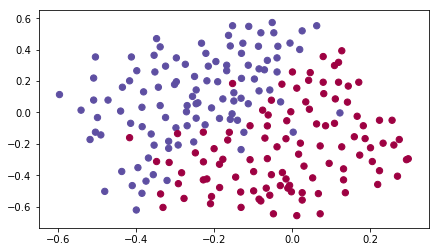

In [2]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

Each dot corresponds to a position on the football field where a football player has hit the ball with his/her head after the French goal keeper has shot the ball from the left side of the football field.
- If the dot is blue, it means the French player managed to hit the ball with his/her head
- If the dot is red, it means the other team's player hit the ball with their head

**Your goal**: Use a deep learning model to find the positions on the field where the goalkeeper should kick the ball.

**Analysis of the dataset**: This dataset is a little noisy, but it looks like a diagonal line separating the upper left half (blue) from the lower right half (red) would work well. 

You will first try a non-regularized model. Then you'll learn how to regularize it and decide which model you will choose to solve the French Football Corporation's problem. 

## 1 - Non-regularized model

You will use the following neural network (already implemented for you below). This model can be used:
- in *regularization mode* -- by setting the `lambd` input to a non-zero value. We use "`lambd`" instead of "`lambda`" because "`lambda`" is a reserved keyword in Python. 
- in *dropout mode* -- by setting the `keep_prob` to a value less than one

You will first try the model without any regularization. Then, you will implement:
- *L2 regularization* -- functions: "`compute_cost_with_regularization()`" and "`backward_propagation_with_regularization()`"
- *Dropout* -- functions: "`forward_propagation_with_dropout()`" and "`backward_propagation_with_dropout()`"

In each part, you will run this model with the correct inputs so that it calls the functions you've implemented. Take a look at the code below to familiarize yourself with the model.

In [3]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (output size, number of examples)
    learning_rate -- learning rate of the optimization
    num_iterations -- number of iterations of the optimization loop
    print_cost -- If True, print the cost every 10000 iterations
    lambd -- regularization hyperparameter, scalar
    keep_prob - probability of keeping a neuron active during drop-out, scalar.
    
    Returns:
    parameters -- parameters learned by the model. They can then be used to predict.
    """
        
    grads = {}
    costs = []                            # to keep track of the cost
    m = X.shape[1]                        # number of examples
    layers_dims = [X.shape[0], 20, 3, 1]
    
    # Initialize parameters dictionary.
    parameters = initialize_parameters(layers_dims)

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # Cost function
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        # Backward propagation.
        assert(lambd==0 or keep_prob==1)    # it is possible to use both L2 regularization and dropout, 
                                            # but this assignment will only explore one at a time
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 10000 iterations
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Let's train the model without any regularization, and observe the accuracy on the train/test sets.

Cost after iteration 0: 0.6557412523481002
Cost after iteration 10000: 0.16329987525724216
Cost after iteration 20000: 0.13851642423255986


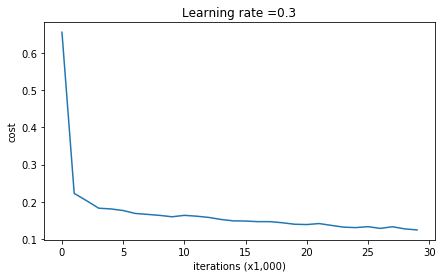

On the training set:
Accuracy: 0.947867298578
On the test set:
Accuracy: 0.915


In [4]:
parameters = model(train_X, train_Y)
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

The train accuracy is 94.8% while the test accuracy is 91.5%. This is the **baseline model** (you will observe the impact of regularization on this model). Run the following code to plot the decision boundary of your model.

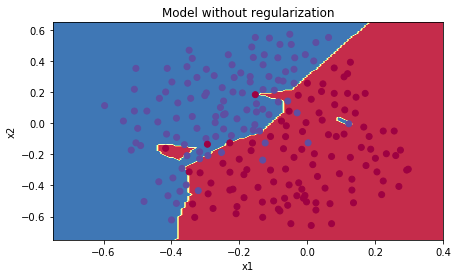

In [5]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

The non-regularized model is obviously overfitting the training set. It is fitting the noisy points! Lets now look at two techniques to reduce overfitting.

## 2 - L2 Regularization

The standard way to avoid overfitting is called **L2 regularization**. It consists of appropriately modifying your cost function, from:
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} \tag{1}$$
To:
$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$

Let's modify your cost and observe the consequences.

**Exercise**: Implement `compute_cost_with_regularization()` which computes the cost given by formula (2). To calculate $\sum\limits_k\sum\limits_j W_{k,j}^{[l]2}$  , use :
```python
np.sum(np.square(Wl))
```
Note that you have to do this for $W^{[1]}$, $W^{[2]}$ and $W^{[3]}$, then sum the three terms and multiply by $ \frac{1}{m} \frac{\lambda}{2} $.

In [6]:
# GRADED FUNCTION: compute_cost_with_regularization

def compute_cost_with_regularization(A3, Y, parameters, lambd):
    """
    Implement the cost function with L2 regularization. See formula (2) above.
    
    Arguments:
    A3 -- post-activation, output of forward propagation, of shape (output size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model
    
    Returns:
    cost - value of the regularized loss function (formula (2))
    """
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(A3, Y) # This gives you the cross-entropy part of the cost
    
    ### START CODE HERE ### (approx. 1 line)
    L2_regularization_cost = (1/m)*(lambd/2)*(np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))
    ### END CODER HERE ###
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [7]:
A3, Y_assess, parameters = compute_cost_with_regularization_test_case()

print("cost = " + str(compute_cost_with_regularization(A3, Y_assess, parameters, lambd = 0.1)))

cost = 1.78648594516


**Expected Output**: 

<table> 
    <tr>
    <td>
    **cost**
    </td>
        <td>
    1.78648594516
    </td>
    
    </tr>

</table> 

Of course, because you changed the cost, you have to change backward propagation as well! All the gradients have to be computed with respect to this new cost. 

**Exercise**: Implement the changes needed in backward propagation to take into account regularization. The changes only concern dW1, dW2 and dW3. For each, you have to add the regularization term's gradient ($\frac{d}{dW} ( \frac{1}{2}\frac{\lambda}{m}  W^2) = \frac{\lambda}{m} W$).

In [8]:
# GRADED FUNCTION: backward_propagation_with_regularization

def backward_propagation_with_regularization(X, Y, cache, lambd):
    """
    Implements the backward propagation of our baseline model to which we added an L2 regularization.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation()
    lambd -- regularization hyperparameter, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    
    ### START CODE HERE ### (approx. 1 line)
    dW3 = 1./m * np.dot(dZ3, A2.T) + (lambd/m)*W3
    ### END CODE HERE ###
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    ### START CODE HERE ### (approx. 1 line)
    dW2 = 1./m * np.dot(dZ2, A1.T) + (lambd/m)*W2
    ### END CODE HERE ###
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    ### START CODE HERE ### (approx. 1 line)
    dW1 = 1./m * np.dot(dZ1, X.T) + (lambd/m)*W1
    ### END CODE HERE ###
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [9]:
X_assess, Y_assess, cache = backward_propagation_with_regularization_test_case()

grads = backward_propagation_with_regularization(X_assess, Y_assess, cache, lambd = 0.7)
print ("dW1 = "+ str(grads["dW1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("dW3 = "+ str(grads["dW3"]))

dW1 = [[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
dW2 = [[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
dW3 = [[-1.77691347 -0.11832879 -0.09397446]]


**Expected Output**:

<table> 
    <tr>
    <td>
    **dW1**
    </td>
        <td>
    [[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
    </td>
    </tr>
    <tr>
    <td>
    **dW2**
    </td>
        <td>
    [[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
    </td>
    </tr>
    <tr>
    <td>
    **dW3**
    </td>
        <td>
    [[-1.77691347 -0.11832879 -0.09397446]]
    </td>
    </tr>
</table> 

Let's now run the model with L2 regularization $(\lambda = 0.7)$. The `model()` function will call: 
- `compute_cost_with_regularization` instead of `compute_cost`
- `backward_propagation_with_regularization` instead of `backward_propagation`

Cost after iteration 0: 0.6974484493131264
Cost after iteration 10000: 0.2684918873282239
Cost after iteration 20000: 0.2680916337127301


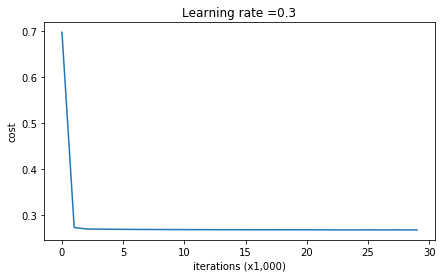

On the train set:
Accuracy: 0.938388625592
On the test set:
Accuracy: 0.93


In [10]:
parameters = model(train_X, train_Y, lambd = 0.7)
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

Congrats, the test set accuracy increased to 93%. You have saved the French football team!

You are not overfitting the training data anymore. Let's plot the decision boundary.

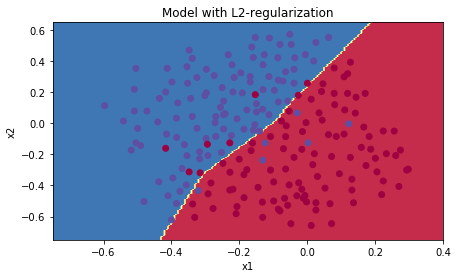

In [11]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

**Observations**:
- The value of $\lambda$ is a hyperparameter that you can tune using a dev set.
- L2 regularization makes your decision boundary smoother. If $\lambda$ is too large, it is also possible to "oversmooth", resulting in a model with high bias.

**What is L2-regularization actually doing?**:

L2-regularization relies on the assumption that a model with small weights is simpler than a model with large weights. Thus, by penalizing the square values of the weights in the cost function you drive all the weights to smaller values. It becomes too costly for the cost to have large weights! This leads to a smoother model in which the output changes more slowly as the input changes. 

<font color='blue'>
**What you should remember** -- the implications of L2-regularization on:
- The cost computation:
    - A regularization term is added to the cost
- The backpropagation function:
    - There are extra terms in the gradients with respect to weight matrices
- Weights end up smaller ("weight decay"): 
    - Weights are pushed to smaller values.

## 3 - Dropout

Finally, **dropout** is a widely used regularization technique that is specific to deep learning. 
**It randomly shuts down some neurons in each iteration.** Watch these two videos to see what this means!

<!--
To understand drop-out, consider this conversation with a friend:
- Friend: "Why do you need all these neurons to train your network and classify images?". 
- You: "Because each neuron contains a weight and can learn specific features/details/shape of an image. The more neurons I have, the more featurse my model learns!"
- Friend: "I see, but are you sure that your neurons are learning different features and not all the same features?"
- You: "Good point... Neurons in the same layer actually don't talk to each other. It should be definitly possible that they learn the same image features/shapes/forms/details... which would be redundant. There should be a solution."
!--> 


<center>
<video width="620" height="440" src="images/dropout1_kiank.mp4" type="video/mp4" controls>
</video>
</center>
<br>
<caption><center> <u> Figure 2 </u>: Drop-out on the second hidden layer. <br> At each iteration, you shut down (= set to zero) each neuron of a layer with probability $1 - keep\_prob$ or keep it with probability $keep\_prob$ (50% here). The dropped neurons don't contribute to the training in both the forward and backward propagations of the iteration. </center></caption>

<center>
<video width="620" height="440" src="images/dropout2_kiank.mp4" type="video/mp4" controls>
</video>
</center>

<caption><center> <u> Figure 3 </u>: Drop-out on the first and third hidden layers. <br> $1^{st}$ layer: we shut down on average 40% of the neurons.  $3^{rd}$ layer: we shut down on average 20% of the neurons. </center></caption>


When you shut some neurons down, you actually modify your model. The idea behind drop-out is that at each iteration, you train a different model that uses only a subset of your neurons. With dropout, your neurons thus become less sensitive to the activation of one other specific neuron, because that other neuron might be shut down at any time. 

### 3.1 - Forward propagation with dropout

**Exercise**: Implement the forward propagation with dropout. You are using a 3 layer neural network, and will add dropout to the first and second hidden layers. We will not apply dropout to the input layer or output layer. 

**Instructions**:
You would like to shut down some neurons in the first and second layers. To do that, you are going to carry out 4 Steps:
1. In lecture, we dicussed creating a variable $d^{[1]}$ with the same shape as $a^{[1]}$ using `np.random.rand()` to randomly get numbers between 0 and 1. Here, you will use a vectorized implementation, so create a random matrix $D^{[1]} = [d^{[1](1)} d^{[1](2)} ... d^{[1](m)}] $ of the same dimension as $A^{[1]}$.
2. Set each entry of $D^{[1]}$ to be 0 with probability (`1-keep_prob`) or 1 with probability (`keep_prob`), by thresholding values in $D^{[1]}$ appropriately. Hint: to set all the entries of a matrix X to 0 (if entry is less than 0.5) or 1 (if entry is more than 0.5) you would do: `X = (X < 0.5)`. Note that 0 and 1 are respectively equivalent to False and True.
3. Set $A^{[1]}$ to $A^{[1]} * D^{[1]}$. (You are shutting down some neurons). You can think of $D^{[1]}$ as a mask, so that when it is multiplied with another matrix, it shuts down some of the values.
4. Divide $A^{[1]}$ by `keep_prob`. By doing this you are assuring that the result of the cost will still have the same expected value as without drop-out. (This technique is also called inverted dropout.)

In [22]:
# GRADED FUNCTION: forward_propagation_with_dropout

def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    """
    Implements the forward propagation: LINEAR -> RELU + DROPOUT -> LINEAR -> RELU + DROPOUT -> LINEAR -> SIGMOID.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape (20, 2)
                    b1 -- bias vector of shape (20, 1)
                    W2 -- weight matrix of shape (3, 20)
                    b2 -- bias vector of shape (3, 1)
                    W3 -- weight matrix of shape (1, 3)
                    b3 -- bias vector of shape (1, 1)
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    A3 -- last activation value, output of the forward propagation, of shape (1,1)
    cache -- tuple, information stored for computing the backward propagation
    """
    
    np.random.seed(1)
    
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    print(A1)
    ### START CODE HERE ### (approx. 4 lines)         # Steps 1-4 below correspond to the Steps 1-4 described above. 
    D1 = np.random.rand(A1.shape[0], A1.shape[1])     # Step 1: initialize matrix D1 = np.random.rand(..., ...)
    D1 = (D1 < keep_prob)                             # Step 2: convert entries of D1 to 0 or 1 (using keep_prob as the threshold)
    A1 = A1*D1                                        # Step 3: shut down some neurons of A1
    print(A1)
    A1 = A1/keep_prob                                 # Step 4: scale the value of neurons that haven't been shut down
    ### END CODE HERE ###
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    print(A2)
    ### START CODE HERE ### (approx. 4 lines)
    D2 = np.random.rand(A2.shape[0], A2.shape[1])     # Step 1: initialize matrix D2 = np.random.rand(..., ...)
    D2 = (D2 < keep_prob)                             # Step 2: convert entries of D2 to 0 or 1 (using keep_prob as the threshold)
    A2 = A2*D2                                        # Step 3: shut down some neurons of A2
    print(A2)
    A2 = A2/keep_prob                                 # Step 4: scale the value of neurons that haven't been shut down
    ### END CODE HERE ###
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

In [23]:
X_assess, parameters = forward_propagation_with_dropout_test_case()

A3, cache = forward_propagation_with_dropout(X_assess, parameters, keep_prob = 0.7)
print ("A3 = " + str(A3))

[[ 0.          3.32524635  2.13994541  2.60700654  0.        ]
 [ 0.          4.1600994   0.79051021  1.46493512  0.        ]]
[[ 0.          0.          2.13994541  2.60700654  0.        ]
 [ 0.          4.1600994   0.79051021  1.46493512  0.        ]]
[[ 0.53035547  5.88414161  3.08385015  4.28707196  0.53035547]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.53035547  5.88414161  3.08385015  0.          0.53035547]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]]
A3 = [[ 0.36974721  0.00305176  0.04565099  0.49683389  0.36974721]]


**Expected Output**: 

<table> 
    <tr>
    <td>
    **A3**
    </td>
        <td>
    [[ 0.36974721  0.00305176  0.04565099  0.49683389  0.36974721]]
    </td>
    
    </tr>

</table> 

### 3.2 - Backward propagation with dropout

**Exercise**: Implement the backward propagation with dropout. As before, you are training a 3 layer network. Add dropout to the first and second hidden layers, using the masks $D^{[1]}$ and $D^{[2]}$ stored in the cache. 

**Instruction**:
Backpropagation with dropout is actually quite easy. You will have to carry out 2 Steps:
1. You had previously shut down some neurons during forward propagation, by applying a mask $D^{[1]}$ to `A1`. In backpropagation, you will have to shut down the same neurons, by reapplying the same mask $D^{[1]}$ to `dA1`. 
2. During forward propagation, you had divided `A1` by `keep_prob`. In backpropagation, you'll therefore have to divide `dA1` by `keep_prob` again (the calculus interpretation is that if $A^{[1]}$ is scaled by `keep_prob`, then its derivative $dA^{[1]}$ is also scaled by the same `keep_prob`).


In [24]:
# GRADED FUNCTION: backward_propagation_with_dropout

def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    """
    Implements the backward propagation of our baseline model to which we added dropout.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation_with_dropout()
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    dA2 = np.dot(W3.T, dZ3)
    ### START CODE HERE ### (≈ 2 lines of code)
    dA2 = dA2*D2                     # Step 1: Apply mask D2 to shut down the same neurons as during the forward propagation
    dA2 = dA2/keep_prob              # Step 2: Scale the value of neurons that haven't been shut down
    ### END CODE HERE ###
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    ### START CODE HERE ### (≈ 2 lines of code)
    dA1 = dA1*D1              # Step 1: Apply mask D1 to shut down the same neurons as during the forward propagation
    dA1 = dA1/keep_prob       # Step 2: Scale the value of neurons that haven't been shut down
    ### END CODE HERE ###
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [25]:
X_assess, Y_assess, cache = backward_propagation_with_dropout_test_case()

gradients = backward_propagation_with_dropout(X_assess, Y_assess, cache, keep_prob = 0.8)

print ("dA1 = " + str(gradients["dA1"]))
print ("dA2 = " + str(gradients["dA2"]))

dA1 = [[ 0.36544439  0.         -0.00188233  0.         -0.17408748]
 [ 0.65515713  0.         -0.00337459  0.         -0.        ]]
dA2 = [[ 0.58180856  0.         -0.00299679  0.         -0.27715731]
 [ 0.          0.53159854 -0.          0.53159854 -0.34089673]
 [ 0.          0.         -0.00292733  0.         -0.        ]]


**Expected Output**: 

<table> 
    <tr>
    <td>
    **dA1**
    </td>
        <td>
    [[ 0.36544439  0.         -0.00188233  0.         -0.17408748]
 [ 0.65515713  0.         -0.00337459  0.         -0.        ]]
    </td>
    
    </tr>
    <tr>
    <td>
    **dA2**
    </td>
        <td>
    [[ 0.58180856  0.         -0.00299679  0.         -0.27715731]
 [ 0.          0.53159854 -0.          0.53159854 -0.34089673]
 [ 0.          0.         -0.00292733  0.         -0.        ]]
    </td>
    
    </tr>
</table> 

Let's now run the model with dropout (`keep_prob = 0.86`). It means at every iteration you shut down each neurons of layer 1 and 2 with 14% probability. The function `model()` will now call:
- `forward_propagation_with_dropout` instead of `forward_propagation`.
- `backward_propagation_with_dropout` instead of `backward_propagation`.

In [ ]:
parameters = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3)

print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.28005504  0.15754854  0.        ]
 [ 0.          0.          0.01022351 ...,  0.11959653  0.09150405  0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.57175484  0.39773852  0.        ]
 [ 0.          0.          0.07347163 ...,  0.37278338  0.28971773  0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.28005504  0.15754854  0.        ]
 [ 0.          0.          0.01022351 ...,  0.11959653  0.09150405  0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.57175484  0.39773852  0.        ]
 [ 0.          0.          0.07347163 ...,  0.37278338  0.28971773  0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
[[  0.00000000e+00   0.0

[[ 0.          0.          0.04127336  0.          0.          0.0194321
   0.01148542  0.          0.          0.          0.23187725  0.29977065
   0.03465148  0.14722198  0.05154236  0.21802799  0.18804135  0.
   0.00205848  0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.01354279
   0.          0.          0.          0.04971159  0.          0.          0.
   0.181497    0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.126717    0.08978957  0.14674027  0.          0.13272433
   0.          

[[ 0.          0.0071674   0.16162237  0.          0.          0.13632125
   0.11830651  0.05771024  0.          0.          0.35991407  0.42176446
   0.15954794  0.23800317  0.1610165   0.33670919  0.28803517  0.
   0.08923311  0.03099016  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.02388817  0.          0.
   0.          0.          0.          0.00729826  0.          0.10437863
   0.          0.          0.          0.13470979  0.03615594  0.          0.
   0.30302916  0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.22438291  0.17507512  0.25655381  0.          0.25139287
   0.05387642 

[[  0.00000000e+00   1.49879028e-01   2.97480665e-01   0.00000000e+00
    4.27648186e-02   2.85021779e-01   2.44044942e-01   1.46947713e-01
    2.43315360e-02   0.00000000e+00   5.06659191e-01   5.69549698e-01
    3.06196624e-01   3.49399704e-01   2.88060043e-01   4.72658973e-01
    4.08507779e-01   5.05849688e-03   1.92245453e-01   1.40211056e-01
    0.00000000e+00   1.89711965e-02   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    2.71830770e-02   1.21064478e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   7.49874047e-02
    0.00000000e+00   1.95064066e-01   0.00000000e+00   0.00000000e+00
    8.61396372e-02   2.10232595e-01   1.01189203e-01   4.02658701e-02
    0.00000000e+00   4.55440705e-01   5.10758724e-02   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.94657489e-02   0.00000000e+00
    1.44664527e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[  0.00000000e+00   3.07619584e-01   4.44456809e-01   0.00000000e+00
    2.24552603e-01   4.45390904e-01   3.62892319e-01   2.43474273e-01
    1.12938831e-01   0.00000000e+00   6.66201131e-01   7.34421685e-01
    4.69375567e-01   4.75165936e-01   4.30316730e-01   6.17223339e-01
    5.43833600e-01   1.37579779e-01   2.85511125e-01   2.63219177e-01
    6.70861403e-02   1.52366255e-01   5.54431764e-02   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.01608613e-01   2.24213261e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.51609600e-01
    8.11004983e-02   2.84766894e-01   4.05279446e-02   0.00000000e+00
    2.22712527e-01   2.94209982e-01   1.73375124e-01   1.16174679e-01
    0.00000000e+00   6.14725121e-01   1.17816886e-01   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.32718277e-01   0.00000000e+00
    2.88367416e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[ 0.          0.46901667  0.59239376  0.          0.41209063  0.60501501
   0.47461944  0.33137316  0.19645085  0.          0.82678839  0.90434915
   0.63427577  0.60147704  0.57157544  0.76537288  0.68056777  0.27130114
   0.35913647  0.38289879  0.16720072  0.28076912  0.18393704  0.13500267
   0.          0.          0.          0.          0.16269286  0.31775388
   0.          0.          0.          0.          0.          0.21530147
   0.20562202  0.36146392  0.08109328  0.          0.35812921  0.36980534
   0.2368844   0.18003302  0.          0.77488036  0.17703742  0.          0.
   0.          0.2392946   0.02439982  0.4162639   0.          0.          0.
   0.          0.          0.          0.          0.          0.05883443
   0.01884023  0.          0.18322254  0.03461244  0.          0.          0.
   0.          0.          0.          0.          0.11753835  0.          0.
   0.01410078  0.          0.          0.          0.          0.53264328
   0.44174057  0.66870

[[  0.00000000e+00   6.17836772e-01   7.25538176e-01   0.00000000e+00
    5.60754374e-01   7.13551243e-01   5.62033167e-01   4.03798034e-01
    2.79461425e-01   0.00000000e+00   9.70639134e-01   1.05307533e+00
    7.68890419e-01   6.93915345e-01   6.89540111e-01   9.00969461e-01
    7.92931582e-01   3.73217978e-01   4.19167764e-01   4.81650586e-01
    2.28593492e-01   3.70697040e-01   2.71003482e-01   2.19056408e-01
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.36660560e-03
    1.93287030e-01   3.81195330e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   2.51330142e-01
    2.89930430e-01   4.11532966e-01   1.02109073e-01   0.00000000e+00
    4.65579273e-01   4.21771935e-01   2.81504683e-01   2.31397342e-01
    0.00000000e+00   8.82594736e-01   2.07560743e-01   0.00000000e+00
    0.00000000e+00   0.00000000e+00   3.02591185e-01   1.26763111e-01
    4.98301106e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[  0.00000000e+00   7.58881746e-01   8.49034414e-01   0.00000000e+00
    6.98899677e-01   8.13046893e-01   6.45366107e-01   4.69279788e-01
    3.58289875e-01   0.00000000e+00   1.10672191e+00   1.19368836e+00
    8.93135653e-01   7.75298303e-01   7.98622104e-01   1.02846767e+00
    8.98326697e-01   4.66154302e-01   4.74855658e-01   5.69228022e-01
    2.70209720e-01   4.47742793e-01   3.51655770e-01   2.93435471e-01
    0.00000000e+00   2.77891420e-02   0.00000000e+00   1.02463984e-02
    2.10995084e-01   4.35921767e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   2.74336794e-01
    3.57618902e-01   4.50538330e-01   1.15653043e-01   0.00000000e+00
    5.60508703e-01   4.67812662e-01   3.15897558e-01   2.78581351e-01
    0.00000000e+00   9.79127020e-01   2.28931738e-01   0.00000000e+00
    0.00000000e+00   0.00000000e+00   3.56151765e-01   2.10043160e-01
    5.71485317e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[  0.00000000e+00   8.92851129e-01   9.64533828e-01   0.00000000e+00
    8.36479513e-01   9.10491381e-01   7.24395757e-01   5.25649406e-01
    4.27002191e-01   0.00000000e+00   1.23816677e+00   1.32929299e+00
    1.01259542e+00   8.50588741e-01   9.02542377e-01   1.14980254e+00
    9.98489530e-01   5.54256687e-01   5.21488453e-01   6.48127335e-01
    3.03478500e-01   5.19421841e-01   4.33139414e-01   3.66495269e-01
    0.00000000e+00   6.96880638e-02   0.00000000e+00   1.04418470e-02
    2.17889443e-01   4.83070327e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   2.85800344e-01
    4.18545942e-01   4.78771189e-01   1.16309054e-01   0.00000000e+00
    6.50534574e-01   5.08220693e-01   3.40273784e-01   3.15007237e-01
    0.00000000e+00   1.07308339e+00   2.42617317e-01   0.00000000e+00
    0.00000000e+00   0.00000000e+00   4.06226303e-01   2.91611218e-01
    6.42093554e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[  0.00000000e+00   1.01501544e+00   1.06846446e+00   0.00000000e+00
    9.58272418e-01   9.91099124e-01   7.87328382e-01   5.66415600e-01
    4.81730232e-01   0.00000000e+00   1.35753607e+00   1.45057229e+00
    1.11602452e+00   9.12111064e-01   9.93979254e-01   1.25859866e+00
    1.08244037e+00   6.29006441e-01   5.44394405e-01   7.01571820e-01
    3.15526367e-01   5.76898822e-01   4.98784308e-01   4.19343312e-01
    0.00000000e+00   9.17372989e-02   0.00000000e+00   0.00000000e+00
    2.06505063e-01   5.13365944e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   2.78741088e-01
    4.62195057e-01   4.88232754e-01   1.02046905e-01   0.00000000e+00
    7.25659566e-01   5.35206791e-01   3.49406521e-01   3.34638027e-01
    0.00000000e+00   1.15087255e+00   2.40779297e-01   0.00000000e+00
    0.00000000e+00   0.00000000e+00   4.38242503e-01   3.52609522e-01
    6.94149958e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[  0.00000000e+00   1.12416354e+00   1.15964841e+00   0.00000000e+00
    1.05992108e+00   1.05330412e+00   8.35434524e-01   5.98876397e-01
    5.30393400e-01   0.00000000e+00   1.46266424e+00   1.55562168e+00
    1.19941950e+00   9.60766584e-01   1.07297072e+00   1.35300182e+00
    1.15207802e+00   6.90034058e-01   5.61966833e-01   7.45694830e-01
    3.12697970e-01   6.17327424e-01   5.45142607e-01   4.52035629e-01
    0.00000000e+00   9.18177423e-02   0.00000000e+00   0.00000000e+00
    1.84795459e-01   5.28253258e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   2.61410473e-01
    4.88314214e-01   4.87146492e-01   8.18950837e-02   0.00000000e+00
    7.85220174e-01   5.55530431e-01   3.51232955e-01   3.45438858e-01
    0.00000000e+00   1.21080813e+00   2.26437490e-01   0.00000000e+00
    0.00000000e+00   0.00000000e+00   4.51889429e-01   3.88446963e-01
    7.26820860e-01   5.90750839e-03   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[  0.00000000e+00   1.21959768e+00   1.23903207e+00   0.00000000e+00
    1.14153412e+00   1.10308288e+00   8.68136835e-01   6.28584312e-01
    5.76739787e-01   0.00000000e+00   1.55240382e+00   1.64354007e+00
    1.27034413e+00   1.00253295e+00   1.14434141e+00   1.43272126e+00
    1.20615394e+00   7.37388612e-01   5.81723311e-01   7.87019414e-01
    3.01103993e-01   6.41771254e-01   5.77666703e-01   4.69275668e-01
    0.00000000e+00   7.13509530e-02   0.00000000e+00   0.00000000e+00
    1.59823975e-01   5.33760037e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   2.40350414e-01
    4.97578300e-01   4.83712597e-01   6.03534709e-02   0.00000000e+00
    8.30090304e-01   5.74641670e-01   3.51590844e-01   3.53949530e-01
    0.00000000e+00   1.25847092e+00   2.05649120e-01   0.00000000e+00
    0.00000000e+00   0.00000000e+00   4.54246208e-01   3.99562734e-01
    7.45673693e-01   1.10880189e-03   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[  0.00000000e+00   1.30341131e+00   1.30835347e+00   0.00000000e+00
    1.21110311e+00   1.14053674e+00   8.93416895e-01   6.53593568e-01
    6.17660939e-01   0.00000000e+00   1.62995986e+00   1.71898698e+00
    1.32656006e+00   1.03564332e+00   1.20495107e+00   1.50085671e+00
    1.25034518e+00   7.76454262e-01   5.99728308e-01   8.22745873e-01
    2.84477412e-01   6.59245533e-01   5.98756765e-01   4.74700991e-01
    0.00000000e+00   4.15521237e-02   0.00000000e+00   0.00000000e+00
    1.32653130e-01   5.30424285e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   2.15050562e-01
    4.94923721e-01   4.77345778e-01   3.63898784e-02   0.00000000e+00
    8.65657641e-01   5.90678449e-01   3.48222789e-01   3.58701934e-01
    0.00000000e+00   1.29349124e+00   1.77491967e-01   0.00000000e+00
    0.00000000e+00   0.00000000e+00   4.46638921e-01   3.98797016e-01
    7.52585282e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[  0.00000000e+00   1.37432101e+00   1.36639910e+00   0.00000000e+00
    1.26547548e+00   1.16370361e+00   9.07585175e-01   6.69363802e-01
    6.50008422e-01   0.00000000e+00   1.69440643e+00   1.78074071e+00
    1.36936419e+00   1.05670871e+00   1.25301664e+00   1.55578788e+00
    1.28221167e+00   8.04821295e-01   6.12293253e-01   8.45774715e-01
    2.58805636e-01   6.63983665e-01   6.05773895e-01   4.65745234e-01
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    9.69040672e-02   5.15185917e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.79777212e-01
    4.82656270e-01   4.62741749e-01   4.44493513e-03   0.00000000e+00
    8.89103799e-01   5.95399734e-01   3.36434870e-01   3.54925081e-01
    0.00000000e+00   1.31524306e+00   1.40160968e-01   0.00000000e+00
    0.00000000e+00   0.00000000e+00   4.27246754e-01   3.83584854e-01
    7.45188667e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[  0.00000000e+00   1.42013920e+00   1.40467727e+00   0.00000000e+00
    1.29381747e+00   1.15387846e+00   8.91379854e-01   6.56612331e-01
    6.55826275e-01   0.00000000e+00   1.73241106e+00   1.81516842e+00
    1.38695876e+00   1.05217303e+00   1.27151164e+00   1.58438696e+00
    1.29078137e+00   8.13381053e-01   6.06467660e-01   8.48231407e-01
    2.00081791e-01   6.43732513e-01   5.79675865e-01   4.20910132e-01
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    3.38337135e-02   4.69314027e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.13702006e-01
    4.46457064e-01   4.21380781e-01   0.00000000e+00   0.00000000e+00
    8.89878784e-01   5.74278520e-01   2.95416618e-01   3.23037236e-01
    0.00000000e+00   1.30398897e+00   7.48829754e-02   0.00000000e+00
    0.00000000e+00   0.00000000e+00   3.76680049e-01   3.35931954e-01
    7.02305450e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[ 0.          1.4575879   1.43631261  0.          1.31194791  1.13008378
   0.86206346  0.63213684  0.64979021  0.          1.76131715  1.84089261
   1.39133689  1.03588951  1.27954487  1.60441427  1.29026286  0.81400134
   0.59238775  0.8438954   0.12823744  0.6156178   0.54196618  0.36178707
   0.          0.          0.          0.          0.          0.41366448
   0.          0.          0.          0.          0.          0.033871
   0.40097705  0.37138076  0.          0.          0.88385734  0.54140985
   0.24227815  0.27921754  0.          1.27965124  0.00393991  0.          0.
   0.          0.3161188   0.27612287  0.6448658   0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.17605193  0.080497    0.          0.          0.          0.
   0.          0.          0.          0.03113694  0.          0.          0.
   0.          0.          0.          0.          0.83174546  0.79661626
   1.32970925  0.   

[[  0.00000000e+00   1.49338888e+00   1.46510510e+00   0.00000000e+00
    1.32862694e+00   1.10671983e+00   8.33705381e-01   6.08433304e-01
    6.43858284e-01   0.00000000e+00   1.78858249e+00   1.86494897e+00
    1.39239504e+00   1.01877210e+00   1.28631777e+00   1.62354024e+00
    1.29195822e+00   8.18081140e-01   5.77396517e-01   8.39036645e-01
    5.92015350e-02   5.92106912e-01   5.04225487e-01   3.04590148e-01
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   3.58255831e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    3.57746669e-01   3.22378989e-01   0.00000000e+00   0.00000000e+00
    8.76754923e-01   5.09006033e-01   1.90932864e-01   2.36255143e-01
    0.00000000e+00   1.25643067e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   2.56512637e-01   2.18954495e-01
    5.89219119e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[  0.00000000e+00   1.54390892e+00   1.50405106e+00   0.00000000e+00
    1.36493080e+00   1.11201462e+00   8.28801106e-01   6.06430344e-01
    6.57465830e-01   0.00000000e+00   1.83130695e+00   1.90587517e+00
    1.41445609e+00   1.02088730e+00   1.31149255e+00   1.65829145e+00
    1.30804011e+00   8.39081110e-01   5.77583775e-01   8.49875726e-01
    2.22724478e-02   5.89341914e-01   4.95277677e-01   2.82638480e-01
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   3.29347992e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    3.42794885e-01   2.95089187e-01   0.00000000e+00   0.00000000e+00
    8.87517767e-01   4.98166907e-01   1.63730166e-01   2.16951743e-01
    0.00000000e+00   1.25834118e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   2.27770078e-01   1.98634243e-01
    5.69937165e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[  0.00000000e+00   1.59380981e+00   1.54222358e+00   0.00000000e+00
    1.39820088e+00   1.11547247e+00   8.24607140e-01   6.07154217e-01
    6.73543135e-01   0.00000000e+00   1.87233597e+00   1.94440177e+00
    1.43372264e+00   1.02308514e+00   1.33643033e+00   1.69223302e+00
    1.32273176e+00   8.57433507e-01   5.79825499e-01   8.63947598e-01
    0.00000000e+00   5.86008735e-01   4.84910665e-01   2.59517510e-01
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   3.02715901e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    3.29617013e-01   2.71686508e-01   0.00000000e+00   0.00000000e+00
    8.96962421e-01   4.89197721e-01   1.40880034e-01   2.02260746e-01
    0.00000000e+00   1.25874710e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.99540475e-01   1.78081830e-01
    5.49619495e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[  0.00000000e+00   1.63957296e+00   1.57554146e+00   0.00000000e+00
    1.42903330e+00   1.12342924e+00   8.26511216e-01   6.12761547e-01
    6.92011558e-01   0.00000000e+00   1.90934584e+00   1.98036712e+00
    1.45491874e+00   1.02780404e+00   1.36044224e+00   1.72308605e+00
    1.33855327e+00   8.80524656e-01   5.86331999e-01   8.80319400e-01
    0.00000000e+00   5.86301791e-01   4.79350292e-01   2.43676393e-01
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   2.80036421e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    3.25681314e-01   2.53686165e-01   0.00000000e+00   0.00000000e+00
    9.08809646e-01   4.82939191e-01   1.23093365e-01   1.94106848e-01
    0.00000000e+00   1.26063493e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.78746568e-01   1.65260172e-01
    5.36487603e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[  0.00000000e+00   1.68435473e+00   1.60800787e+00   0.00000000e+00
    1.45619977e+00   1.12997969e+00   8.28803892e-01   6.20382555e-01
    7.12674155e-01   0.00000000e+00   1.94499451e+00   2.01385327e+00
    1.47284627e+00   1.03332779e+00   1.38519060e+00   1.75290602e+00
    1.35261076e+00   8.99247860e-01   5.95199784e-01   9.00120006e-01
    0.00000000e+00   5.85160943e-01   4.72204555e-01   2.25165833e-01
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   2.57392128e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    3.22522926e-01   2.38703080e-01   0.00000000e+00   0.00000000e+00
    9.18961871e-01   4.77488816e-01   1.08681474e-01   1.89617910e-01
    0.00000000e+00   1.25926622e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.57241414e-01   1.50241831e-01
    5.22152313e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[  0.00000000e+00   1.72782051e+00   1.63717061e+00   0.00000000e+00
    1.48054278e+00   1.13622151e+00   8.31011812e-01   6.29500033e-01
    7.34913634e-01   0.00000000e+00   1.97942719e+00   2.04503981e+00
    1.48966884e+00   1.03972218e+00   1.41064147e+00   1.78183792e+00
    1.36664721e+00   9.16717234e-01   6.04409372e-01   9.19207390e-01
    0.00000000e+00   5.84284404e-01   4.65196857e-01   2.07553845e-01
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   2.36720483e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    3.20637717e-01   2.25234913e-01   0.00000000e+00   0.00000000e+00
    9.27852689e-01   4.72922562e-01   9.57241181e-02   1.88115482e-01
    0.00000000e+00   1.25905989e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.38384187e-01   1.35885716e-01
    5.08485949e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[  0.00000000e+00   1.76650698e+00   1.66249157e+00   0.00000000e+00
    1.50290596e+00   1.14115327e+00   8.28290138e-01   6.33392722e-01
    7.51072376e-01   0.00000000e+00   2.00929350e+00   2.07121179e+00
    1.50609262e+00   1.04569502e+00   1.43261343e+00   1.80650324e+00
    1.37928069e+00   9.34614023e-01   6.08745884e-01   9.31184458e-01
    0.00000000e+00   5.82465293e-01   4.57793424e-01   1.90927155e-01
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   2.16315834e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    3.14423301e-01   2.07261461e-01   0.00000000e+00   0.00000000e+00
    9.35716444e-01   4.64921651e-01   7.77291100e-02   1.82260820e-01
    0.00000000e+00   1.25845853e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.20740325e-01   1.22690766e-01
    4.94236237e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[  0.00000000e+00   1.79909645e+00   1.68281039e+00   0.00000000e+00
    1.51928810e+00   1.14063252e+00   8.21368507e-01   6.31066670e-01
    7.61112501e-01   0.00000000e+00   2.03302988e+00   2.09070445e+00
    1.51743389e+00   1.04799102e+00   1.44980562e+00   1.82543429e+00
    1.38761964e+00   9.48405027e-01   6.08816014e-01   9.37381805e-01
    0.00000000e+00   5.76506014e-01   4.45589394e-01   1.69403541e-01
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.92472926e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    3.04613803e-01   1.84466693e-01   0.00000000e+00   0.00000000e+00
    9.39255435e-01   4.51532329e-01   5.42839141e-02   1.70955093e-01
    0.00000000e+00   1.25325266e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   9.98942372e-02   1.04593353e-01
    4.74698821e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[  0.00000000e+00   1.82764192e+00   1.69974269e+00   0.00000000e+00
    1.53202603e+00   1.13711212e+00   8.11367020e-01   6.27887219e-01
    7.69885986e-01   0.00000000e+00   2.05285193e+00   2.10632475e+00
    1.52500447e+00   1.04797992e+00   1.46372254e+00   1.84072803e+00
    1.39338973e+00   9.59571006e-01   6.08724668e-01   9.43084649e-01
    0.00000000e+00   5.68394811e-01   4.30663482e-01   1.45277677e-01
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.66573896e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    2.93341836e-01   1.61649104e-01   0.00000000e+00   0.00000000e+00
    9.39994033e-01   4.37485622e-01   2.82762504e-02   1.59482272e-01
    0.00000000e+00   1.24474596e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   7.74865335e-02   8.46953186e-02
    4.52796204e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[  0.00000000e+00   1.85519886e+00   1.71582992e+00   0.00000000e+00
    1.54552068e+00   1.13395548e+00   8.01834843e-01   6.23125109e-01
    7.76757059e-01   0.00000000e+00   2.07202325e+00   2.12147502e+00
    1.53249341e+00   1.04691758e+00   1.47705226e+00   1.85555487e+00
    1.40005751e+00   9.71671191e-01   6.07015747e-01   9.47354756e-01
    0.00000000e+00   5.62740979e-01   4.17582928e-01   1.23460592e-01
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.42899721e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    2.83170473e-01   1.39158948e-01   0.00000000e+00   0.00000000e+00
    9.41614663e-01   4.22841664e-01   1.87664022e-03   1.46300562e-01
    0.00000000e+00   1.23718852e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   5.66385912e-02   6.74560101e-02
    4.32560980e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[ 0.          1.88228335  1.73192825  0.          1.56048357  1.12773217
   0.7905197   0.61575135  0.78033368  0.          2.09075983  2.13617869
   1.5373705   1.04251701  1.48553297  1.87012877  1.40793304  0.98525693
   0.60283013  0.95243013  0.          0.55882448  0.40301071  0.10102465
   0.          0.          0.          0.          0.          0.11763857
   0.          0.          0.          0.          0.          0.
   0.27506331  0.11611075  0.          0.          0.94472638  0.4081384
   0.          0.13057838  0.          1.22816082  0.          0.          0.
   0.          0.03512098  0.05229952  0.41040774  0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.79523581  0.86663324
   1.45847625  0.          

[[  0.00000000e+00   1.91079071e+00   1.74911016e+00   0.00000000e+00
    1.57976166e+00   1.12600183e+00   7.82497618e-01   6.10974596e-01
    7.86107128e-01   0.00000000e+00   2.11140041e+00   2.15329318e+00
    1.54525740e+00   1.04022426e+00   1.49622911e+00   1.88661292e+00
    1.41860059e+00   1.00133227e+00   6.00480748e-01   9.59674300e-01
    0.00000000e+00   5.60082733e-01   3.95054004e-01   8.61619847e-02
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   9.83993118e-02   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    2.71564598e-01   9.77203083e-02   0.00000000e+00   0.00000000e+00
    9.50938879e-01   3.96887358e-01   0.00000000e+00   1.17776936e-01
    0.00000000e+00   1.22384783e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   2.02918864e-02   4.52740603e-02
    3.95007267e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[  0.00000000e+00   1.94331440e+00   1.77075209e+00   0.00000000e+00
    1.60638548e+00   1.13420584e+00   7.83812255e-01   6.14831052e-01
    7.99585035e-01   0.00000000e+00   2.13626518e+00   2.17513412e+00
    1.56193293e+00   1.04627321e+00   1.51331844e+00   1.90738024e+00
    1.43136370e+00   1.02038366e+00   6.05921248e-01   9.72042430e-01
    0.00000000e+00   5.65513918e-01   3.98352865e-01   8.47897669e-02
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   8.99005340e-02   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    2.76972442e-01   8.92607478e-02   0.00000000e+00   0.00000000e+00
    9.63089943e-01   3.95205506e-01   0.00000000e+00   1.14398354e-01
    0.00000000e+00   1.22998120e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.77430852e-02   5.03434520e-02
    3.91748405e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[ 0.          1.96672939  1.78699619  0.          1.62457117  1.13850583
   0.78427195  0.61780938  0.8094743   0.          2.15359712  2.19003304
   1.57310805  1.0507689   1.52555648  1.92183744  1.43917537  1.03234782
   0.6105177   0.98017213  0.          0.56713401  0.39913201  0.08174186
   0.          0.          0.          0.          0.          0.08339626
   0.          0.          0.          0.          0.          0.
   0.27961553  0.08346735  0.          0.          0.97093514  0.39411705
   0.          0.11246688  0.          1.23335607  0.          0.          0.
   0.          0.0152356   0.05134654  0.38706063  0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.79493392  0.8825584
   1.48530827  0.          

[[  0.00000000e+00   1.99444398e+00   1.80561216e+00   0.00000000e+00
    1.64734838e+00   1.14328121e+00   7.83448645e-01   6.19822038e-01
    8.20117589e-01   0.00000000e+00   2.17361539e+00   2.20708877e+00
    1.58621861e+00   1.05524366e+00   1.53868148e+00   1.93821659e+00
    1.44836689e+00   1.04756315e+00   6.15090690e-01   9.89080068e-01
    0.00000000e+00   5.69137187e-01   4.00219128e-01   7.85018978e-02
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   7.47022085e-02   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    2.83423511e-01   7.49558883e-02   0.00000000e+00   0.00000000e+00
    9.80132446e-01   3.91455491e-01   0.00000000e+00   1.08518930e-01
    0.00000000e+00   1.23692804e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.29680802e-02   5.42031915e-02
    3.81203118e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[ 0.05466325  0.          0.         ...,  0.          0.          0.02360458]
 [ 0.          0.          0.         ...,  0.38768611  0.26302769  0.        ]
 [ 0.          0.          0.         ...,  0.10243514  0.07436908  0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.62481694  0.45181495  0.        ]
 [ 0.          0.          0.         ...,  0.23603517  0.16069281  0.        ]
 [ 0.          0.          0.         ...,  0.14451941  0.11729988
   0.09492556]]
[[ 0.05466325  0.          0.         ...,  0.          0.          0.02360458]
 [ 0.          0.          0.         ...,  0.38768611  0.26302769  0.        ]
 [ 0.          0.          0.         ...,  0.10243514  0.07436908  0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.62481694  0.45181495  0.        ]
 [ 0.          0.          0.         ...,  0.23603517  0.16069281  0.        ]
 [ 0.          0.          0.         ...,  0.14451941  0.          0.09492556]]
[[  1.15806362e+00   2

[[  0.00000000e+00   2.04251742e+00   1.83629795e+00   0.00000000e+00
    1.68802539e+00   1.15245942e+00   7.81592119e-01   6.23597032e-01
    8.40500958e-01   0.00000000e+00   2.20681370e+00   2.23463413e+00
    1.61081395e+00   1.06408381e+00   1.56252824e+00   1.96473782e+00
    1.46362864e+00   1.07556701e+00   6.25252323e-01   1.00306989e+00
    0.00000000e+00   5.71533025e-01   4.03009174e-01   7.46113909e-02
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   5.85198772e-02   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    2.91223767e-01   5.94001255e-02   0.00000000e+00   0.00000000e+00
    9.95081127e-01   3.87595042e-01   0.00000000e+00   1.01804541e-01
    0.00000000e+00   1.24425184e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.11352448e-02   6.13221040e-02
    3.71410204e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[ 0.04846497  0.          0.         ...,  0.          0.          0.01822201]
 [ 0.          0.          0.         ...,  0.38343668  0.2590211   0.        ]
 [ 0.          0.          0.         ...,  0.10196195  0.07391404  0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.6276833   0.45484085  0.        ]
 [ 0.          0.          0.         ...,  0.22914016  0.15406797  0.        ]
 [ 0.          0.          0.         ...,  0.1454471   0.          0.09241907]]
[[  1.18668488e+00   2.06674587e+00   1.85068364e+00   2.41053033e+00
    1.71037278e+00   1.15660877e+00   7.78627907e-01   6.20749870e-01
    8.47849767e-01   1.42326372e+00   2.22223187e+00   2.24679999e+00
    1.62371038e+00   1.06740712e+00   1.57324843e+00   1.97636904e+00
    1.47146684e+00   1.09156520e+00   6.27914578e-01   1.00813847e+00
    0.00000000e+00   5.72845268e-01   4.04648074e-01   7.25216877e-02
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   4

[[ 0.          2.07787228  1.85667431  0.          1.71831644  1.15404902
   0.77321774  0.61658467  0.8499067   0.          2.2276326   2.24988356
   1.62710322  1.06633487  1.57674813  1.97974136  1.47271785  1.09759414
   0.6281538   1.00889413  0.          0.56918712  0.40000892  0.06473296
   0.          0.          0.          0.          0.          0.03720383
   0.          0.          0.          0.          0.          0.
   0.29381321  0.03630231  0.          0.          1.00318995  0.37648573
   0.          0.08552827  0.          1.24265357  0.          0.          0.
   0.          0.00374576  0.06164818  0.35550876  0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.79281357  0.90830299
   1.51766605  0.         

[[ 0.          2.09440104  1.86576018  0.          1.73495752  1.15677844
   0.76978319  0.61240906  0.85347512  0.          2.2375633   2.25747967
   1.63586452  1.06686629  1.5825446   1.98687048  1.47834848  1.10966986
   0.62911811  1.01167774  0.          0.57084887  0.40245905  0.06454727
   0.          0.          0.          0.          0.          0.02815426
   0.          0.          0.          0.          0.          0.
   0.29795032  0.0264931   0.          0.          1.00889378  0.37142671
   0.          0.07706996  0.          1.24390327  0.          0.          0.
   0.          0.00437483  0.06717866  0.35167683  0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.78929881  0.91139368
   1.52190705  0.         

[[  0.00000000e+00   2.10916844e+00   1.87337207e+00   0.00000000e+00
    1.74888827e+00   1.15770908e+00   7.65356020e-01   6.08241189e-01
    8.56913716e-01   0.00000000e+00   2.24556155e+00   2.26296634e+00
    1.64312484e+00   1.06653500e+00   1.58746396e+00   1.99223326e+00
    1.48200712e+00   1.12017609e+00   6.30683397e-01   1.01344827e+00
    0.00000000e+00   5.70197232e-01   4.03051496e-01   6.23797967e-02
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.81902696e-02   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    3.00897870e-01   1.65212370e-02   0.00000000e+00   0.00000000e+00
    1.01326800e+00   3.66145386e-01   0.00000000e+00   6.88837490e-02
    0.00000000e+00   1.24359339e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   4.05717332e-03   7.00887595e-02
    3.46045895e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[  0.00000000e+00   2.12356770e+00   1.88064132e+00   0.00000000e+00
    1.76183910e+00   1.15937298e+00   7.62074666e-01   6.05145849e-01
    8.61681085e-01   0.00000000e+00   2.25322899e+00   2.26807014e+00
    1.65109427e+00   1.06773856e+00   1.59373630e+00   1.99737350e+00
    1.48569087e+00   1.13101376e+00   6.33608103e-01   1.01520464e+00
    0.00000000e+00   5.69435946e-01   4.03552536e-01   6.11446518e-02
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   8.59265159e-03   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    3.04512150e-01   7.25800638e-03   0.00000000e+00   0.00000000e+00
    1.01714407e+00   3.61982732e-01   0.00000000e+00   6.19583629e-02
    0.00000000e+00   1.24469991e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   4.07540824e-03   7.34759019e-02
    3.41325491e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[  0.00000000e+00   2.12962806e+00   1.88065630e+00   0.00000000e+00
    1.76638338e+00   1.14887044e+00   7.47064410e-01   5.90138720e-01
    8.54059985e-01   0.00000000e+00   2.25239363e+00   2.26447514e+00
    1.64705210e+00   1.05943214e+00   1.58776668e+00   1.99420515e+00
    1.48395028e+00   1.13642358e+00   6.26155890e-01   1.01065967e+00
    0.00000000e+00   5.60972667e-01   3.91314297e-01   4.64906095e-02
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    3.01843302e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.01394792e+00   3.46310126e-01   0.00000000e+00   4.45619528e-02
    0.00000000e+00   1.23225571e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   6.80873035e-02
    3.23947672e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[  0.00000000e+00   2.13681344e+00   1.87839252e+00   0.00000000e+00
    1.77095216e+00   1.13766492e+00   7.31116408e-01   5.72901108e-01
    8.45527943e-01   0.00000000e+00   2.25207856e+00   2.26135348e+00
    1.64272574e+00   1.05350882e+00   1.58059442e+00   1.99116040e+00
    1.47979721e+00   1.14148364e+00   6.16290879e-01   1.00313908e+00
    0.00000000e+00   5.46756100e-01   3.74409513e-01   2.83018247e-02
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    3.01390238e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.01140592e+00   3.28661118e-01   0.00000000e+00   2.53791452e-02
    0.00000000e+00   1.21669782e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   6.20881871e-02
    3.04580683e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[  0.00000000e+00   2.14735871e+00   1.87825669e+00   0.00000000e+00
    1.77734067e+00   1.13013191e+00   7.19197695e-01   5.60851004e-01
    8.42376834e-01   0.00000000e+00   2.25487369e+00   2.26126600e+00
    1.64239495e+00   1.05162967e+00   1.57815497e+00   1.99106870e+00
    1.47788164e+00   1.14474397e+00   6.10093110e-01   9.97231241e-01
    0.00000000e+00   5.34623410e-01   3.60968976e-01   1.34961277e-02
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    3.02235779e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.01054040e+00   3.15299477e-01   0.00000000e+00   1.03946664e-02
    0.00000000e+00   1.20534530e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   5.75087311e-02
    2.88596030e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[  0.00000000e+00   2.15802201e+00   1.87801714e+00   0.00000000e+00
    1.78439169e+00   1.12416162e+00   7.08857504e-01   5.49464198e-01
    8.39799900e-01   0.00000000e+00   2.25782165e+00   2.26142543e+00
    1.64366296e+00   1.05296544e+00   1.57571830e+00   1.99100848e+00
    1.47830846e+00   1.14678452e+00   6.03701032e-01   9.93578959e-01
    0.00000000e+00   5.21972209e-01   3.48608434e-01   7.41742425e-04
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    3.06653817e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00987840e+00   3.03177326e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.19540331e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   5.72731789e-02
    2.74462583e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[  0.00000000e+00   2.16993629e+00   1.87823492e+00   0.00000000e+00
    1.79322017e+00   1.12355358e+00   7.03593583e-01   5.43470955e-01
    8.42395284e-01   0.00000000e+00   2.26208808e+00   2.26299533e+00
    1.64989492e+00   1.05916682e+00   1.57780297e+00   1.99219323e+00
    1.48257960e+00   1.15108255e+00   6.00878799e-01   9.91852521e-01
    0.00000000e+00   5.12263519e-01   3.42028792e-01   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    3.13368151e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.01017328e+00   2.96628903e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.19048613e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   6.12231931e-02
    2.66250215e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[  0.00000000e+00   2.18193471e+00   1.88095030e+00   0.00000000e+00
    1.80169591e+00   1.11977533e+00   6.95041164e-01   5.34815970e-01
    8.42140588e-01   0.00000000e+00   2.26687985e+00   2.26539974e+00
    1.65273029e+00   1.05940821e+00   1.57824089e+00   1.99385375e+00
    1.48375843e+00   1.15521201e+00   5.97596960e-01   9.88948852e-01
    0.00000000e+00   5.05898406e-01   3.33764367e-01   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    3.15180275e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.01049346e+00   2.87072733e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.18378480e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   5.97824090e-02
    2.55394729e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[  0.00000000e+00   2.19541093e+00   1.88535442e+00   0.00000000e+00
    1.81189187e+00   1.11815580e+00   6.89025156e-01   5.28877680e-01
    8.44534206e-01   0.00000000e+00   2.27300807e+00   2.26899867e+00
    1.65777201e+00   1.06101884e+00   1.58067213e+00   1.99693147e+00
    1.48623300e+00   1.16028786e+00   5.95386824e-01   9.87289977e-01
    0.00000000e+00   5.00709396e-01   3.27649470e-01   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    3.16792566e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.01110367e+00   2.81045044e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.17850402e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   5.90344496e-02
    2.46589561e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[  0.00000000e+00   2.20909093e+00   1.89046812e+00   0.00000000e+00
    1.82131600e+00   1.11479579e+00   6.81520280e-01   5.22203061e-01
    8.46084233e-01   0.00000000e+00   2.27936509e+00   2.27275012e+00
    1.66054671e+00   1.06188051e+00   1.58281446e+00   2.00027298e+00
    1.48778232e+00   1.16374100e+00   5.92917345e-01   9.86413203e-01
    0.00000000e+00   4.94448180e-01   3.20650283e-01   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    3.17479342e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.01133832e+00   2.73686964e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.17236444e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   5.69236012e-02
    2.36114266e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

[[  0.00000000e+00   2.21693258e+00   1.89000101e+00   0.00000000e+00
    1.82466828e+00   1.10506154e+00   6.67902118e-01   5.09453154e-01
    8.41590633e-01   0.00000000e+00   2.27991216e+00   2.27065295e+00
    1.65597669e+00   1.05759573e+00   1.57845540e+00   1.99772172e+00
    1.48895011e+00   1.16542644e+00   5.84507065e-01   9.81026512e-01
    0.00000000e+00   4.87506709e-01   3.07855731e-01   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    3.13323984e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00581029e+00   2.60435821e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.15998488e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   4.99345180e-02
    2.19353644e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

Dropout works great! The test accuracy has increased again (to 95%)! Your model is not overfitting the training set and does a great job on the test set. The French football team will be forever grateful to you! 

Run the code below to plot the decision boundary.

In [ ]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

**Note**:
- A **common mistake** when using dropout is to use it both in training and testing. You should use dropout (randomly eliminate nodes) only in training. 
- Deep learning frameworks like [tensorflow](https://www.tensorflow.org/api_docs/python/tf/nn/dropout), [PaddlePaddle](http://doc.paddlepaddle.org/release_doc/0.9.0/doc/ui/api/trainer_config_helpers/attrs.html), [keras](https://keras.io/layers/core/#dropout) or [caffe](http://caffe.berkeleyvision.org/tutorial/layers/dropout.html) come with a dropout layer implementation. Don't stress - you will soon learn some of these frameworks.

<font color='blue'>
**What you should remember about dropout:**
- Dropout is a regularization technique.
- You only use dropout during training. Don't use dropout (randomly eliminate nodes) during test time.
- Apply dropout both during forward and backward propagation.
- During training time, divide each dropout layer by keep_prob to keep the same expected value for the activations. For example, if keep_prob is 0.5, then we will on average shut down half the nodes, so the output will be scaled by 0.5 since only the remaining half are contributing to the solution. Dividing by 0.5 is equivalent to multiplying by 2. Hence, the output now has the same expected value. You can check that this works even when keep_prob is other values than 0.5.  

## 4 - Conclusions

**Here are the results of our three models**: 

<table> 
    <tr>
        <td>
        **model**
        </td>
        <td>
        **train accuracy**
        </td>
        <td>
        **test accuracy**
        </td>

    </tr>
        <td>
        3-layer NN without regularization
        </td>
        <td>
        95%
        </td>
        <td>
        91.5%
        </td>
    <tr>
        <td>
        3-layer NN with L2-regularization
        </td>
        <td>
        94%
        </td>
        <td>
        93%
        </td>
    </tr>
    <tr>
        <td>
        3-layer NN with dropout
        </td>
        <td>
        93%
        </td>
        <td>
        95%
        </td>
    </tr>
</table> 

Note that regularization hurts training set performance! This is because it limits the ability of the network to overfit to the training set. But since it ultimately gives better test accuracy, it is helping your system. 

Congratulations for finishing this assignment! And also for revolutionizing French football. :-) 

<font color='blue'>
**What we want you to remember from this notebook**:
- Regularization will help you reduce overfitting.
- Regularization will drive your weights to lower values.
- L2 regularization and Dropout are two very effective regularization techniques.